# Semeval 2025 Task 10
### Subtask 1: Entity Framing

Given a news article and a list of mentions of named entities (NEs) in the article, assign for each such mention one or more roles using a predefined taxonomy of fine-grained roles covering three main type of roles: protagonists, antagonists, and innocent. This is a multi-label multi-class text-span classification task.

## 1. Importing libraries

In [1]:
# Instructor compatible with these versions only
!pip install -q huggingface_hub==0.23.5
!pip install -q langchain==0.1.2 sentence_transformers==2.2.2

In [2]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint

from matplotlib import pyplot as plt
import seaborn as sns
import os


In [3]:
!pip install InstructorEmbedding

## 2. Reading our data


We will go ahead and start by reading the annotations from the subtask-1.

* The annotations are our ground-truths.
For each article we read it's id, it's entity which is by-default given to us, and the class/sub-class where it belongs to.

In [4]:
raw_annotation_data = []

with open("data/semeval_data/subtask-1-annotations.txt", 'r') as file:
    for line in file:
        parts = line.strip().split('\t')
        raw_annotation_data.append(parts)

annotations_df = pd.DataFrame(raw_annotation_data)

In [5]:
annotations_df.head()

,0,1,2,3,4,5,6
0,EN_UA_103861.txt,Chinese,791,797,Antagonist,Spy,None
1,EN_UA_103861.txt,China,1516,1520,Antagonist,Instigator,None
2,EN_UA_103861.txt,Hamas,2121,2125,Antagonist,Terrorist,None
3,EN_UA_103861.txt,Donald Trump,4909,4920,Protagonist,Peacemaker,Guardian
4,EN_UA_021270.txt,Yermak,667,672,Antagonist,Incompetent,None


In [6]:
annotations_df.shape

(414, 7)

For simplicity, we will ignore the `fine-grained_roles` attribute for, as it requires further thinking on how to handle a specific article on having multiple roles.

For now, we will focus on trying to classify each entity on it's `main_role` and then move from there.

We will also rename our labels to represent the actual ones:

In [7]:
annotations_df.rename(columns={0: 'article_id', 1: 'entity_mention', 2: 'start_offset',
                   3: 'end_offset', 4: 'main_role', 5: 'fine_grained_roles',
                   6: 'additional_info'}, inplace=True)

annotations_df.head()

,article_id,entity_mention,start_offset,end_offset,main_role,fine_grained_roles,additional_info
0,EN_UA_103861.txt,Chinese,791,797,Antagonist,Spy,None
1,EN_UA_103861.txt,China,1516,1520,Antagonist,Instigator,None
2,EN_UA_103861.txt,Hamas,2121,2125,Antagonist,Terrorist,None
3,EN_UA_103861.txt,Donald Trump,4909,4920,Protagonist,Peacemaker,Guardian
4,EN_UA_021270.txt,Yermak,667,672,Antagonist,Incompetent,None


Notice that in a single article, we can have the same entity mentioned playing different roles:

In [8]:
annotations_df[annotations_df['article_id'] == 'EN_UA_013257.txt']

,article_id,entity_mention,start_offset,end_offset,main_role,fine_grained_roles,additional_info
398,EN_UA_013257.txt,Russia,375,380,Protagonist,Underdog,None
399,EN_UA_013257.txt,Russia,944,949,Innocent,Victim,None
400,EN_UA_013257.txt,Russia,1590,1595,Protagonist,Guardian,None
401,EN_UA_013257.txt,Western countries,1667,1683,Antagonist,Saboteur,None
402,EN_UA_013257.txt,Russia,1763,1768,Protagonist,Virtuous,None


In [9]:
# To be changed, for simplity now
annotations_df.drop(columns=['fine_grained_roles', 'additional_info'], inplace=True)
annotations_df.head()

,article_id,entity_mention,start_offset,end_offset,main_role
0,EN_UA_103861.txt,Chinese,791,797,Antagonist
1,EN_UA_103861.txt,China,1516,1520,Antagonist
2,EN_UA_103861.txt,Hamas,2121,2125,Antagonist
3,EN_UA_103861.txt,Donald Trump,4909,4920,Protagonist
4,EN_UA_021270.txt,Yermak,667,672,Antagonist


Also, notice that in the `article_id` the beginning of it, the `EN_*` part, is irrelevant to us.

We will go ahead and remove it and only keep the id of the article which is the part we actually want.

In [10]:
def extract_article_id(filename):
    number_part = filename.split('_')[-1].split('.')[0]
    return number_part

print(extract_article_id('EN_UA_103861.txt'))

103861


In [11]:
annotations_df['article_id'] = annotations_df['article_id'].apply(extract_article_id)
annotations_df.head()

,article_id,entity_mention,start_offset,end_offset,main_role
0,103861,Chinese,791,797,Antagonist
1,103861,China,1516,1520,Antagonist
2,103861,Hamas,2121,2125,Antagonist
3,103861,Donald Trump,4909,4920,Protagonist
4,021270,Yermak,667,672,Antagonist


We will know read our actual articles.

In [12]:
def read_file_content(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()


We create a placeholder dataframe, that is going to be filled up.

There are 2 columns that we are seeking, the `article_id` and the actual `content` of that.

In [13]:
documents_df = pd.DataFrame(columns=['article_id', 'content'])

In [14]:
folder_path = "data/semeval_data/raw-documents"

for filename in os.listdir(folder_path):
    if filename.endswith('.txt') and filename.startswith('EN'):
        article_id = extract_article_id(filename)
        file_path = os.path.join(folder_path, filename)
        content = read_file_content(file_path)

        new_row = pd.DataFrame({'article_id': [article_id], 'content': [content]})

        documents_df = pd.concat([documents_df, new_row], ignore_index=True)

documents_df.head()

,article_id,content
0,104876,Putin honours army unit blamed for Bucha massa...
1,023211,Europe Putin thanks US journalist Tucker Carls...
2,011260,Russia has a clear plan to resolve the conflic...
3,101067,"First war of TikTok era sees tragedy, humor an..."
4,102963,Ukraine's President Zelenskyy to address Mexic...


There are 200 articles that are given to us for this task:

In [15]:
documents_df.shape

(200, 2)

We then merge our dataframes into a single dataframe constisting.

The derived dataframe has the following columns:

* `article_id`
* `content`
* `entity_mention`
* The entity's starting and ending position in the article
* The ground truth of the entity.

In [16]:
dataset = pd.merge(documents_df, annotations_df, on='article_id')
dataset.head()

,article_id,content,entity_mention,start_offset,end_offset,main_role
0,104876,Putin honours army unit blamed for Bucha massa...,VLADIMIR Putin,90,103,Antagonist
1,104876,Putin honours army unit blamed for Bucha massa...,President Volodymyr Zelensky,2305,2332,Protagonist
2,011260,Russia has a clear plan to resolve the conflic...,Ukraine,263,269,Antagonist
3,011260,Russia has a clear plan to resolve the conflic...,Russia,637,642,Protagonist
4,011260,Russia has a clear plan to resolve the conflic...,Ukrainian leadership,830,849,Antagonist


In [17]:
print(dataset.iloc[4].content)

Russia has a clear plan to resolve the conflict in Ukraine 

 The conflict in Ukraine may end either by diplomatic or military means. However, it can be possible only after Moscow achieves its goals.

"An opportunity to resolve the conflict will appear only when Ukraine ceases to pose a threat to Russia and discriminate against Russian-speaking Ukrainians,” Vasily Nebenzya, Russia's Ambassador to the UN Security Council, said at a briefing at the UN Security Council.

"If this result can be achieved through negotiations, we are ready for such a scenario. If not, then our objectives will be achieved by military means," he added.

Russia is not fighting against the Ukrainian people. Russia is fighting against the criminal nationalist regime that came to power in 2014” after the coup in Kyiv, the diplomat said.

"The new Ukrainian leadership is trying to purge the country of everything connected with Russia and glorify Nazi accomplices. <…>

"The Kyiv regime and its most rabid patrons hav

Since the annotations where limited to `417`, we also expect that the merged dataframe will be of that size:

In [18]:
dataset.shape

(417, 6)

We also do a sanity-check to see if there are any missing values:

In [19]:
dataset.isnull().sum()

article_id        0
content           0
entity_mention    0
start_offset      0
end_offset        0
main_role         0
dtype: int64

Notice that the distributions of roles are uneven, with the `Antagonist` being the most common class, and `Innocent` being the least common.

This should worry us, and we should keep this in mind when attempting to find a good classifier.

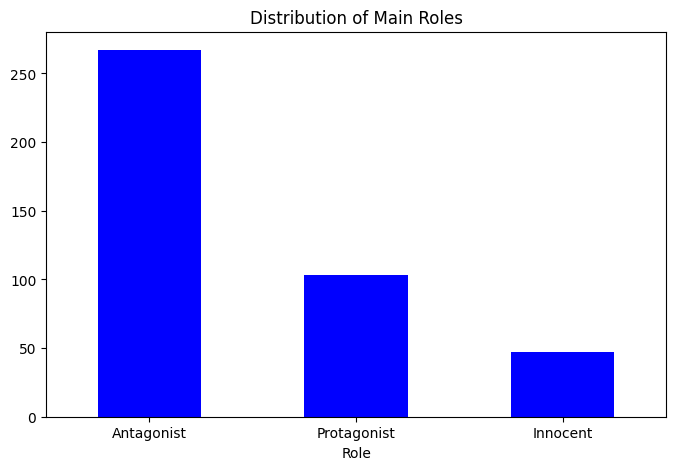

In [20]:
role_counts = dataset['main_role'].value_counts()

plt.figure(figsize=(8, 5))
role_counts.plot(kind='bar', color=['blue'])
plt.title('Distribution of Main Roles')
plt.xlabel('Role')
plt.xticks(rotation=0)
plt.show()

## 3. Preparing our data

We now begin by processing our data and preparing it in order to find a good, initial/baseline classifier for this task.


Our goal is to classify those entities into 3 classes:
* `Protagonist`
* `Antagonist`
* `Innocent`

It's obvious that this task is an instance of a supervised learning, we have some features and we are also given the ground truth, the class where each entity truly belongs to.

We begin by shuffling our data:

In [21]:
random_state = 42 # used for experimentantions
dataset = dataset.sample(frac=1)
dataset.head()

,article_id,content,entity_mention,start_offset,end_offset,main_role
167,024321,Molotov Cocktail Attack On Russian Embassy In ...,Moscow,1667,1672,Antagonist
340,200021,NYC to begin tracking food purchases to make s...,Adams,679,683,Antagonist
245,013344,I was a KGB spy along side Putin and he IS usi...,Zhirnov,1329,1335,Protagonist
254,100106,Election in Nigeria triggers deluge of 'misinf...,Al Gore,488,494,Antagonist
26,026142,Oppose imperialist War! SEP/IYSSE public meeti...,Zionist,2564,2570,Antagonist


In [22]:
print(dataset.iloc[1].content)

NYC to begin tracking food purchases to make sure residents don’t consume “too much” meat 


Just as he promised to do, New York City Mayor Eric Adams, a left-wing Democrat, is going after people’s meat with new plans to save the world from “climate change” by forcing everyone to become a “plant-based” vegetarian or vegan.

Along with representatives from the Mayor’s Office of Food Policy and the Mayor’s Office of Climate & Environmental Justice, Adams has announced the launch of a new “carbon footprint” and household food consumption tracking scheme that aims to reduce the Big Apple’s “carbon emissions” by 33 percent by the year 2030.


In order to cut all that carbon, Adams and his allies are imposing new “caps on meat” that, as the name suggests, will limit the amount of meat that New Yorkers are allowed to purchase and consume at public institutions – and eventually within their own homes as well.

(Related: Last month, we warned you that Adams was planning to unleash a horrific ne

### 3.1 Training a baseline model

We will begin by seeing how good of a job traditional machine learning models can do for this kind of tasks.

Our idea is simple, since we have the `start_offset` and `end_offset` of each entity, we can also get the nearby x words of that entity surrounding it, before and after:

In [23]:
def get_context(row, window=150):
    content = row['content']
    start = int(row['start_offset'])
    end = int(row['end_offset'])

    words = content.split()

    pre_entity_text = content[:start].split()
    post_entity_text = content[end + 1:].split()

    # Get context words before and after
    context_before = " ".join(pre_entity_text[-window:])
    context_after = " ".join(post_entity_text[:window])

    return context_before, context_after

dataset['context_before'], dataset['context_after'] = zip(*dataset.apply(get_context, axis=1))

In [24]:
example_context = "Moscow: Russia will ask the UN Security Council for an investigation"
entity_mention = "Russia"
start_offset = 8
end_offset = 13

example_df = pd.DataFrame({
    'content': [example_context],
    'entity_mention': [entity_mention],
    'start_offset': [start_offset],
    'end_offset': [end_offset]
})

example_df

,content,entity_mention,start_offset,end_offset
0,Moscow: Russia will ask the UN Security Counci...,Russia,8,13


In [25]:
get_context(example_df.iloc[0])

('Moscow:', 'will ask the UN Security Council for an investigation')

The article in row 1, has the entity mentioned:

In [26]:
dataset.iloc[1].entity_mention

'Adams'

Context before the entity:

In [27]:
dataset.iloc[1].context_before

'NYC to begin tracking food purchases to make sure residents don’t consume “too much” meat Just as he promised to do, New York City Mayor Eric Adams, a left-wing Democrat, is going after people’s meat with new plans to save the world from “climate change” by forcing everyone to become a “plant-based” vegetarian or vegan. Along with representatives from the Mayor’s Office of Food Policy and the Mayor’s Office of Climate & Environmental Justice, Adams has announced the launch of a new “carbon footprint” and household food consumption tracking scheme that aims to reduce the Big Apple’s “carbon emissions” by 33 percent by the year 2030. In order to cut all that carbon,'

Context after the entity:

In [28]:
dataset.iloc[1].context_after

'and his allies are imposing new “caps on meat” that, as the name suggests, will limit the amount of meat that New Yorkers are allowed to purchase and consume at public institutions – and eventually within their own homes as well. (Related: Last month, we warned you that Adams was planning to unleash a horrific new food policing apparatus against New Yorkers, and now he has.) Eric Adams wants all New Yorkers to become vegans At a pre-Earth Day event held at a Brooklyn culinary center run by NYC Health + Hospitals, the city’s public health care system, Adams unveiled a chart depicting New York City’s greenhouse gas inventory. This inventory supposedly tracks the carbon footprint generated by household food consumption. With the help of American Express, C40 Cities, and EcoData, Adams revealed carbon emissions data about household food consumption, which was added to existing carbon emissions data on energy'

In [29]:
dataset.iloc[1].main_role

'Antagonist'

We also do again a sanity check that our results are correct:

In [30]:
dataset.iloc[1].content

'NYC to begin tracking food purchases to make sure residents don’t consume “too much” meat \n\n\nJust as he promised to do, New York City Mayor Eric Adams, a left-wing Democrat, is going after people’s meat with new plans to save the world from “climate change” by forcing everyone to become a “plant-based” vegetarian or vegan.\n\nAlong with representatives from the Mayor’s Office of Food Policy and the Mayor’s Office of Climate & Environmental Justice, Adams has announced the launch of a new “carbon footprint” and household food consumption tracking scheme that aims to reduce the Big Apple’s “carbon emissions” by 33 percent by the year 2030.\n\n\nIn order to cut all that carbon, Adams and his allies are imposing new “caps on meat” that, as the name suggests, will limit the amount of meat that New Yorkers are allowed to purchase and consume at public institutions – and eventually within their own homes as well.\n\n(Related: Last month, we warned you that Adams was planning to unleash a 

We then combine the ccontext before and after the entity to a single, `entity_context`.

In [31]:
dataset['entity_context'] = dataset['context_before'] + " " + dataset['entity_mention'] + " " + dataset['context_after']

In [32]:
dataset.iloc[1].entity_context

'NYC to begin tracking food purchases to make sure residents don’t consume “too much” meat Just as he promised to do, New York City Mayor Eric Adams, a left-wing Democrat, is going after people’s meat with new plans to save the world from “climate change” by forcing everyone to become a “plant-based” vegetarian or vegan. Along with representatives from the Mayor’s Office of Food Policy and the Mayor’s Office of Climate & Environmental Justice, Adams has announced the launch of a new “carbon footprint” and household food consumption tracking scheme that aims to reduce the Big Apple’s “carbon emissions” by 33 percent by the year 2030. In order to cut all that carbon, Adams and his allies are imposing new “caps on meat” that, as the name suggests, will limit the amount of meat that New Yorkers are allowed to purchase and consume at public institutions – and eventually within their own homes as well. (Related: Last month, we warned you that Adams was planning to unleash a horrific new food

In [33]:
dataset.head()

,article_id,content,entity_mention,start_offset,end_offset,main_role,context_before,context_after,entity_context
167,024321,Molotov Cocktail Attack On Russian Embassy In ...,Moscow,1667,1672,Antagonist,incident in the small country of Moldova which...,was breaking laws by printing ballot papers in...,incident in the small country of Moldova which...
340,200021,NYC to begin tracking food purchases to make s...,Adams,679,683,Antagonist,NYC to begin tracking food purchases to make s...,and his allies are imposing new “caps on meat”...,NYC to begin tracking food purchases to make s...
245,013344,I was a KGB spy along side Putin and he IS usi...,Zhirnov,1329,1335,Protagonist,Zhirnov said he had believed until now that cl...,is now exiled in France and was a former class...,Zhirnov said he had believed until now that cl...
254,100106,Election in Nigeria triggers deluge of 'misinf...,Al Gore,488,494,Antagonist,Election in Nigeria triggers deluge of 'misinf...,this ahead of the forthcoming polls.” A BBC re...,Election in Nigeria triggers deluge of 'misinf...
26,026142,Oppose imperialist War! SEP/IYSSE public meeti...,Zionist,2564,2570,Antagonist,war for domination as the only way out. War is...,regime and its imperialist backers have not on...,war for domination as the only way out. War is...


In [34]:
!pip install emoji

In [35]:
import spacy
import re
import emoji

nlp = spacy.load("en_core_web_sm")

def clean_article(article_text):
    # Remove URLs
    article_text = re.sub(r'http\S+|www\S+|https\S+|[a-zA-Z0-9.-]+\.com', '', article_text, flags=re.MULTILINE)

    doc = nlp(article_text)
    cleaned_tokens = []

    for token in doc:
        if (token.is_space or '@' in token.text or emoji.is_emoji(token.text)):
            continue

        cleaned_tokens.append(token.text + token.whitespace_)

    cleaned_article = "".join(cleaned_tokens).strip()

    return cleaned_article

In [36]:
dataset['entity_context'] = dataset['entity_context'].apply(clean_article)
dataset.iloc[3].entity_context

"Election in Nigeria triggers deluge of 'misinformation' on social media New Delhi: Ahead of the presidential election in Nigeria, there has been an explosion of fake news across social media platforms. Divisive content on subjects like religion and ethnicity is also littered across social media networks like Facebook, Twitter, TikTok and WhatsApp. According to a report in Al Jazeera, “Social media allows Nigerians to share information in real-time, political strategists are weapo Al Gore this ahead of the forthcoming polls.” A BBC report in January uncovered how Nigerian politicians secretly paid social media influencers as much as 20 million Nigerian naira ($43,000) or promised government contracts and political appointments to spread disinformation about opponents. Some of these influencers are also being recruited to “situation rooms” to monitor the spread of the fake news, the report added. Meanwhile, Nigeria is grappling with widespread fuel shortages that are forcing motorists t

In [37]:
dataset.iloc[1].entity_context

'NYC to begin tracking food purchases to make sure residents don’t consume “too much” meat Just as he promised to do, New York City Mayor Eric Adams, a left-wing Democrat, is going after people’s meat with new plans to save the world from “climate change” by forcing everyone to become a “plant-based” vegetarian or vegan. Along with representatives from the Mayor’s Office of Food Policy and the Mayor’s Office of Climate & Environmental Justice, Adams has announced the launch of a new “carbon footprint” and household food consumption tracking scheme that aims to reduce the Big Apple’s “carbon emissions” by 33 percent by the year 2030. In order to cut all that carbon, Adams and his allies are imposing new “caps on meat” that, as the name suggests, will limit the amount of meat that New Yorkers are allowed to purchase and consume at public institutions – and eventually within their own homes as well. (Related: Last month, we warned you that Adams was planning to unleash a horrific new food

In [38]:
dataset.iloc[3]

article_id                                                   100106
content           Election in Nigeria triggers deluge of 'misinf...
entity_mention                                              Al Gore
start_offset                                                    488
end_offset                                                      494
main_role                                                Antagonist
context_before    Election in Nigeria triggers deluge of 'misinf...
context_after     this ahead of the forthcoming polls.” A BBC re...
entity_context    Election in Nigeria triggers deluge of 'misinf...
Name: 254, dtype: object

In [39]:
dataset['entity_context'].iloc[4]

'war for domination as the only way out. War is being accompanied by savage repression against any opposition as the terrible, continued persecution of Julian Assange for exposing the crimes of US imperialism graphically demonstrates. Our comrade Bogdan Syrotiuk of the Young Guard of Bolshevik Leninists has been detained by the fascistic Zelensky government in Ukraine earlier this month on false accusations of being a Russian agent. Bogdan has courageously opposed the war in Ukraine, along with his comrades in Russia, denounced both the Ukrainian and Russian regimes and fought for the unity of the Ukrainian and Russian working class. In the US and other imperialist countries, brutal police crackdowns are taking place against protesters opposing the Gaza genocide with thousands of arrests including of students. The ongoing anti-war protests in universities and cities are significant, but on their own are incapable of halting the bloodbath. For seven months, the Zionist regime and its im

In [40]:
dataset['main_role'].iloc[4]

'Antagonist'

In [41]:
dataset['entity_mention'].iloc[4]

'Zionist'

In [42]:
from sklearn.preprocessing import LabelEncoder

_le = LabelEncoder()
dataset['main_role_encoded'] = _le.fit_transform(dataset['main_role'])

In [43]:
dataset['main_role_encoded']

167    0
340    0
245    2
254    0
26     0
      ..
411    2
3      2
54     0
402    0
255    0
Name: main_role_encoded, Length: 417, dtype: int64

In [44]:
from sklearn.model_selection import train_test_split
dataset_train, dataset_temp = train_test_split(dataset, train_size=0.85, shuffle=True, stratify=dataset['main_role_encoded'])

In [45]:
dataset_val, dataset_test = train_test_split(dataset_temp, train_size=0.5, shuffle=True, stratify=dataset_temp['main_role_encoded'])

In [46]:
dataset_test.main_role.value_counts()

main_role
Antagonist     20
Protagonist     8
Innocent        4
Name: count, dtype: int64

In [47]:
import warnings
from sklearn.metrics import classification_report, confusion_matrix

def get_classification_report(y_true, y_pred):
  # Ignore warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        report = classification_report(y_true, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    return report_df

def plot_confusion_matrix(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    return conf_matrix

In [48]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def evaluate_model(model, x, y_true):
  y_pred = model.predict(x)
  classification_report_df = get_classification_report(y_true, y_pred)
  print(classification_report_df)
  print('\n')
  conf = plot_confusion_matrix(y_true, y_pred)
  return conf

def get_cross_val_score(model, x, y, scoring='f1_macro', splits=3):
  cv = StratifiedKFold(n_splits=splits, shuffle=True)
  cross_val_scores = cross_val_score(model, x, y, cv=cv, scoring=scoring)
  print(f"Cross-validation scores: {cross_val_scores}")
  print(f"Mean CV F1 Score: {cross_val_scores.mean()}")

In [49]:
import os

def embeddings_exist(embeddings_path):
    embeddings_files = [
        'train_embeddings.npy',
        'val_embeddings.npy',
        'test_embeddings.npy',
    ]
    # Check if all required embedding files exist
    for embedding_file in embeddings_files:
        path = os.path.join(embeddings_path, embedding_file) 
        if not os.path.exists(path):
            return False
    return True

In [50]:
model = None
embeddings_dir = 'data/embeddings/entity_framing/'

if not embeddings_exist(embeddings_dir):
    from InstructorEmbedding import INSTRUCTOR
    model = INSTRUCTOR('hkunlp/instructor-large')
else:
    print("Skipping loading model")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/InstructorEmbedding/instructor.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange


load INSTRUCTOR_Transformer
max_seq_length  512


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1602: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sentence_transformers/models/Dense.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the 

In [51]:
print(model)

INSTRUCTOR(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: T5EncoderModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False})
  (2): Dense({'in_features': 1024, 'out_features': 768, 'bias': False, 'activation_function': 'torch.nn.modules.linear.Identity'})
  (3): Normalize()
)


In [52]:
def get_instructor_embeddings(dataset):
    embeddings = []
    for index, row in dataset.iterrows():
        entity = row['entity_mention']
        context = row['entity_context']
        instruction = (
            f"Classify the role of {entity} in this context as antagonist, protagonist, or innocent. Focus on their "
            f"actions, intent, and surrounding sentiment: "
        )
        embedding = model.encode([[instruction, context]])
        embeddings.append(embedding[0])

    return np.array(embeddings)

In [53]:
train_embeddings_path = os.path.join(embeddings_dir, 'train_embeddings.npy')
val_embeddings_path = os.path.join(embeddings_dir, 'val_embeddings.npy')
test_embeddings_path = os.path.join(embeddings_dir, 'test_embeddings.npy')

def load_embeddings(file_path):
  if os.path.exists(file_path):
      print(f"Loading embeddings from {file_path}")
      return np.load(file_path)
  else:
      print(f"No embeddings found at {file_path}")
      return None

def save_embeddings(embeddings, file_path):
    np.save(file_path, embeddings)
    print(f"Embeddings saved to {file_path}")

def ensure_embeddings(dataset, dataset_type='train'):
    if dataset_type == 'train':
        embeddings_path = train_embeddings_path
    elif dataset_type == 'val':
        embeddings_path = val_embeddings_path
    elif dataset_type == 'test':
        embeddings_path = test_embeddings_path
    else:
        print('Dataset type must be either train, val or test')
        return

    embeddings = load_embeddings(embeddings_path)

    if embeddings is None:
        print(f"Generating {dataset_type} embeddings...")
        embeddings = get_instructor_embeddings(dataset)
        save_embeddings(embeddings, embeddings_path)

    return embeddings

In [54]:
train_x_embeddings = ensure_embeddings(dataset_train, dataset_type='train')
val_x_embeddings = ensure_embeddings(dataset_val, dataset_type='val')

No embeddings found at data/embeddings/entity_framing/train_embeddings.npy
Generating train embeddings...
Embeddings saved to data/embeddings/entity_framing/train_embeddings.npy
No embeddings found at data/embeddings/entity_framing/val_embeddings.npy
Generating val embeddings...
Embeddings saved to data/embeddings/entity_framing/val_embeddings.npy


In [55]:
train_x_embeddings.shape

(354, 768)

In [56]:
train_x_embeddings[0][:20]

array([-0.01067423, -0.04770148, -0.01568508,  0.02918606,  0.0589218 ,
        0.02481545,  0.00112661,  0.00801194, -0.06015591,  0.06214703,
        0.07781693,  0.00377271,  0.02326236,  0.02937167, -0.03854338,
       -0.04004407, -0.0407858 ,  0.0423594 , -0.03022785,  0.0068551 ],
      dtype=float32)

In [57]:
train_x_embeddings[1][:20]

array([-0.03175866, -0.01766243, -0.01718685,  0.01814671,  0.07748958,
        0.00992958,  0.00991318,  0.01980518, -0.03723301,  0.04197976,
        0.07476486, -0.01666038, -0.00676561,  0.05177666, -0.02166705,
       -0.03690792, -0.03741233,  0.06025   , -0.06721244, -0.02630915],
      dtype=float32)

In [58]:
train_y_encoded = dataset_train['main_role_encoded'].reset_index(drop=True)
val_y_encoded = dataset_val['main_role_encoded'].reset_index(drop=True)

train_y_encoded

0      2
1      0
2      0
3      1
4      1
      ..
349    0
350    0
351    0
352    0
353    0
Name: main_role_encoded, Length: 354, dtype: int64

In [59]:
test_y_embeddings = ensure_embeddings(dataset_test, dataset_type='test')
test_y_encoded = dataset_test['main_role_encoded'].reset_index(drop=True)

No embeddings found at data/embeddings/entity_framing/test_embeddings.npy
Generating test embeddings...
Embeddings saved to data/embeddings/entity_framing/test_embeddings.npy


In [60]:
from sklearn.neighbors import KNeighborsClassifier

knn_classifier = KNeighborsClassifier(n_neighbors=3, weights='distance', metric='cosine')
get_cross_val_score(knn_classifier, train_x_embeddings, train_y_encoded)

Cross-validation scores: [0.39263102 0.45362109 0.41886724]
Mean CV F1 Score: 0.42170645343615304


              precision    recall  f1-score    support
0              0.736842  0.700000  0.717949  20.000000
1              0.500000  0.333333  0.400000   3.000000
2              0.500000  0.625000  0.555556   8.000000
accuracy       0.645161  0.645161  0.645161   0.645161
macro avg      0.578947  0.552778  0.557835  31.000000
weighted avg   0.652801  0.645161  0.645272  31.000000




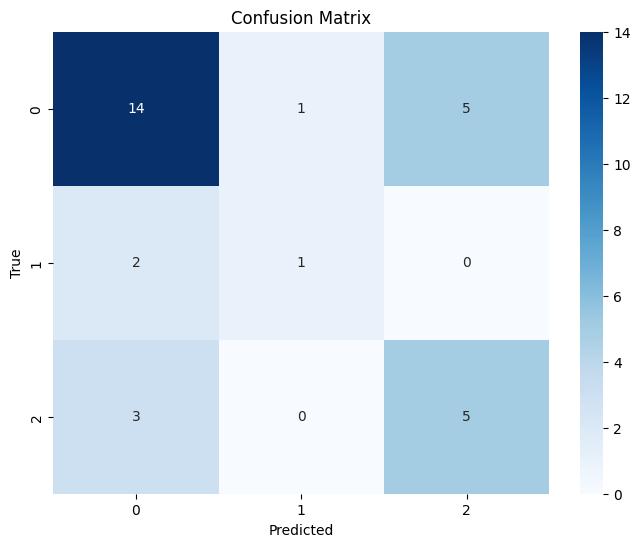

array([[14,  1,  5],
       [ 2,  1,  0],
       [ 3,  0,  5]])

In [61]:
knn_classifier.fit(train_x_embeddings, train_y_encoded)
evaluate_model(knn_classifier, val_x_embeddings, val_y_encoded)

In [62]:
import xgboost as xgb
from xgboost import XGBClassifier

xgb_classifier = XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=150)
get_cross_val_score(xgb_classifier, train_x_embeddings, train_y_encoded)

Cross-validation scores: [0.39096551 0.43152845 0.49285714]
Mean CV F1 Score: 0.4384503675580855


              precision    recall  f1-score    support
0              0.636364  0.700000  0.666667  20.000000
1              0.000000  0.000000  0.000000   3.000000
2              0.375000  0.375000  0.375000   8.000000
accuracy       0.548387  0.548387  0.548387   0.548387
macro avg      0.337121  0.358333  0.347222  31.000000
weighted avg   0.507331  0.548387  0.526882  31.000000




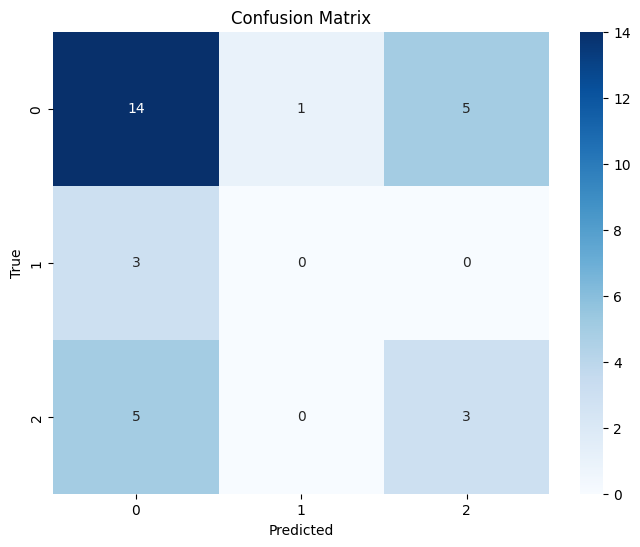

array([[14,  1,  5],
       [ 3,  0,  0],
       [ 5,  0,  3]])

In [63]:
xgb_classifier.fit(train_x_embeddings, train_y_encoded)
evaluate_model(xgb_classifier, val_x_embeddings, val_y_encoded)

In [64]:
label = _le.inverse_transform([1])
print(label)

['Innocent']


In [65]:
from collections import Counter
Counter(train_y_encoded)

Counter({0: 227, 2: 87, 1: 40})

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

weak_learner = DecisionTreeClassifier(max_depth=5)
adaboost_classifier = AdaBoostClassifier(estimator=weak_learner, n_estimators=100, learning_rate=.1)

get_cross_val_score(adaboost_classifier, train_x_embeddings, train_y_encoded)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [ ]:
adaboost_classifier.fit(train_x_embeddings, train_y_encoded)

In [ ]:
evaluate_model(adaboost_classifier, val_x_embeddings, val_y_encoded)

In [ ]:
from sklearn.utils import class_weight

classes = np.unique(train_y_encoded)
class_weights = class_weight.compute_class_weight('balanced', classes=classes, y=train_y_encoded)
class_weights

In [ ]:
class_weights_dict = dict(zip(classes, class_weights))
class_weights_dict

In [ ]:
custom_class_weights = {
    0: 0.5,  # Antagonist
    1: 3.5,  # Innocent (increased from 2.95)
    2: 1.5   # Protagonist (slightly increased)
}

In [ ]:
sample_weights = np.array([custom_class_weights[label] for label in train_y_encoded])

In [ ]:
sample_weights

In [ ]:
import xgboost as xgb

xgb_weighted = xgb.XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=150)
get_cross_val_score(xgb_weighted, train_x_embeddings, train_y_encoded)

In [ ]:
xgb_weighted.fit(train_x_embeddings, train_y_encoded, sample_weight=sample_weights)
evaluate_model(xgb_weighted, val_x_embeddings, val_y_encoded)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

decision_tree_weighted = DecisionTreeClassifier(max_depth=5, class_weight=custom_class_weights)
adaboost_weighted = AdaBoostClassifier(estimator=decision_tree_weighted, n_estimators=150, learning_rate=.1)
get_cross_val_score(adaboost_weighted, train_x_embeddings, train_y_encoded)

In [ ]:
adaboost_weighted.fit(train_x_embeddings, train_y_encoded, sample_weight=sample_weights)

In [ ]:
evaluate_model(adaboost_weighted, val_x_embeddings, val_y_encoded)

In [ ]:
from sklearn.svm import SVC

svm_classifier = SVC(C=10, gamma='scale', kernel='rbf') # attributes after running GridSearch
svm_classifier.fit(train_x_embeddings, train_y_encoded, sample_weight=sample_weights)

In [ ]:
get_cross_val_score(svm_classifier, train_x_embeddings, train_y_encoded)

In [ ]:
evaluate_model(svm_classifier, val_x_embeddings, val_y_encoded)

In [ ]:
classes = len(np.unique(train_y_encoded))

embedding_dim = train_x_embeddings.shape[1]

small_model = tf.keras.Sequential([
    keras.layers.InputLayer(input_shape=(embedding_dim,)),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(classes, activation='softmax')
])

In [ ]:
def compile_and_fit(x_train, y_train, model, optimizer=None, max_epochs=100, callbacks=[], lr=0.01, use_class_weights=False):
    if not optimizer:
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
      metrics=['accuracy']
    )

    history = model.fit(
        x_train, y_train,
        epochs=max_epochs,
        validation_data=(val_x_embeddings, val_y_encoded),
        callbacks=callbacks,
        verbose=2,
        class_weight=class_weights_dict if use_class_weights else None
    )
    return history

In [ ]:
def plot_history(history, metric='loss'):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history[metric], label=f'Training {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

def evaluate_mlp(model, X, y):
    y_pred_prob = model.predict(X)
    y_pred = np.argmax(y_pred_prob, axis=-1)

    print("Classification Report:")
    print(classification_report(y, y_pred))

    print("Confusion Matrix:")
    cm = confusion_matrix(y, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
hist_small = compile_and_fit(train_x_embeddings, train_y_encoded, small_model)

In [ ]:
plot_history(hist_small)

In [ ]:
evaluate_mlp(small_model, val_x_embeddings, val_y_encoded)

In [ ]:
import time

def pause():
    try:
      while True:
          time.sleep(60)
    except KeyboardInterrupt:
      print("Stopped")


In [ ]:
# pause()